In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import fsolve, newton, bisect
from scipy.interpolate import interp1d, splrep, sproot, PPoly
import yaml

In [3]:
with open('solver_kwargs.yaml', 'r') as file:
    solver_kwargs = yaml.safe_load(file)

In [49]:
plt.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.linewidth'] = 2 
plt.rcParams.update({"text.usetex": False})
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)
plt.rc('axes', grid = True)

In [5]:
np.random.seed(0)
rng = lambda n=1: np.random.randn(n)
rng_ = lambda n, d=2: np.random.randn(n, d)
norm = stats.norm
dt = 1. / 252.

In [6]:
nbStrike = 21
sizeSample = 5000

In [7]:
from utilsCdfHagan import *
from utilsClv import *
from utilsImpVol import blackscholes_impv
from utilsPrices import *
from utilsSampleDef import *

In [8]:
mdl_params_xt = {'kappa': 1.3, 'theta': 0.1, 'sigma': 0.25}

In [9]:
utils_clv = utilsClv(mdl_params_xt, rng)
utils_def = utilsDef(nbStrike, sizeSample)

Modèle benchmark

In [14]:
def generate_sabr(s_0, sig_0, mdl_params, matur, r, n_samples, freq = 1.):
    alpha, beta, rho = mdl_params.values()
    time_step = freq * dt
    disc_steps = int(matur / time_step)

    f = np.empty((n_samples, disc_steps + 1))
    f[:, 0] = s_0 * np.exp(r * matur)
    sig = np.empty((n_samples, disc_steps + 1))
    sig[:, 0] = sig_0
    s = np.empty((n_samples, disc_steps + 1))
    s[:, 0] = s_0

    for n in range(1, disc_steps + 1):
        z = rng_(n_samples)
        z_1, z_2 = z[:, 0], z[:, 1]

        #f[:, n] = f[:, n - 1] + np.sqrt(time_step) * sig[:, n - 1] * np.sqrt(np.clip(f[:, n - 1], 0., f[:, n - 1].max())) * z_1
        f[:, n] = f[:, n - 1] + np.sqrt(time_step) * sig[:, n - 1] * np.sqrt(np.abs(f[:, n - 1])) * z_1
        s[:, n] = f[:, n] * np.exp(- r * (matur - dt * n))
        sig[:, n] = sig[:, n - 1] + np.sqrt(time_step) * alpha * sig[:, n - 1] * (rho * z_1 + np.sqrt(1 - rho**2) * z_2)

    return s

In [15]:
mdl_params_sabr = {'alpha': 0.2, 'beta': 0.5, 'rho': -0.9}
s_0, sig_0 = 1., 0.2
x_0 = s_0
maturities = np.array([0.05, 0.25, .5, 1., 2., 3., 4.])
matur = maturities[-1]
r = 3e-2
n_samples = 100_000

In [16]:
s_sbr = generate_sabr(s_0, sig_0, mdl_params_sabr, matur, r, n_samples)

Market cdf

In [11]:
log_m = np.linspace(-.5, .5, 25)
forwards_  = get_forwards(maturities, s_0)
strikes = np.empty((log_m.shape[0], maturities.shape[0]))
for n in range(maturities.shape[0]):
    strikes[:, n] = forwards_[n] * np.exp(log_m)

In [12]:
market_surface = implied_vol_hagan(maturities, strikes, forwards_)
price_surface = get_price_surface(s_0, maturities, strikes, market_surface)
market_cdf_comp  = get_market_cdf(s_0, strikes, maturities, forwards_, deriv = 'complex', eps = 1e-100)

In [13]:
price_put_surface = get_price_surface_put(s_0, maturities, strikes, market_surface)

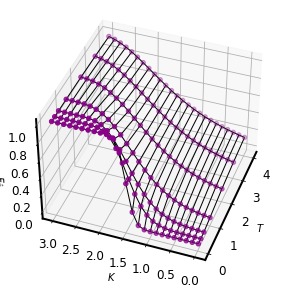

In [14]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ss = np.linspace(0, 3, 25)
X, Y = np.meshgrid(maturities, ss)
ax.plot_wireframe(X, Y, market_cdf_comp, color = "k",  lw = 1.)
#ax.plot_surface(X, Y, market_cdf, cmap = 'viridis')
ax.scatter(X, Y, market_cdf_comp, color = 'darkmagenta')
ax.view_init(40, -160)
ax.set_xlabel(r'$T$')
ax.set_ylabel(r'$K$')
ax.set_zlabel(r'$F_{\hat{S}_T}}$')
plt.tight_layout()

In [58]:
s_T_sbr = s_sbr[:, np.where(t_grid == 4.)[0][0]]

In [59]:
price_sbr_T = call_MC(maturities[6], s_T_sbr, r = 0.03, strikes = strikes[:, 6])
imp_vol_T = blackscholes_impv(K = strikes[:, 6], T = maturities[6], S = s_0, value = price_sbr_T, r =0.03, callput = 'call')

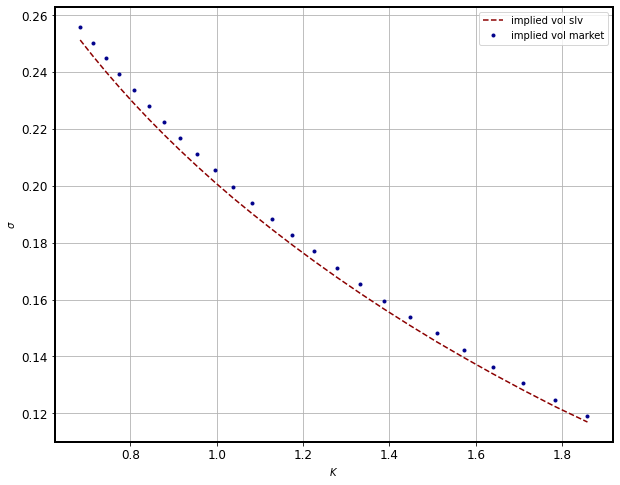

In [62]:
plt.plot(strikes[:, 6], imp_vol_T, '--', label = 'implied vol slv', color = 'darkred')
plt.plot(strikes[:, 6], market_surface[:, 6], '.', label = 'implied vol market', color = 'darkblue')
plt.xlabel(r'$K$')
plt.ylabel(r'$\sigma$')
plt.legend()

In [64]:
def price_call_mc(maturities, strikes, spots_):
    out = np.empty_like(strikes)
    for n, mat in enumerate(maturities):
        out[:, n] = np.exp(-r * mat) * np.maximum(np.subtract.outer(spots_[n, :], strikes[:, n]), 0.).mean(0)
    return out

In [65]:
exercice_dates = maturities[1:]

In [66]:
spot_samples = np.empty((n_samples, exercice_dates.shape[0]))
for i in range(spot_samples.shape[1]):
    spot_samples[:, i] = s_sbr[:, np.where(t_grid == exercice_dates[i])[0][0]]

In [67]:
call_price = price_call_mc(exercice_dates, strikes, spot_samples.T)

In [68]:
vol_clv = np.empty_like(call_price)
for n, mat in enumerate(exercice_dates):
    vol_clv[:, n] = blackscholes_impv(K = strikes[:, n], T = mat, S = s_0, value = call_price[:, n], r =0.03, callput = 'call')

In [80]:
plt.rc('axes', grid = True)

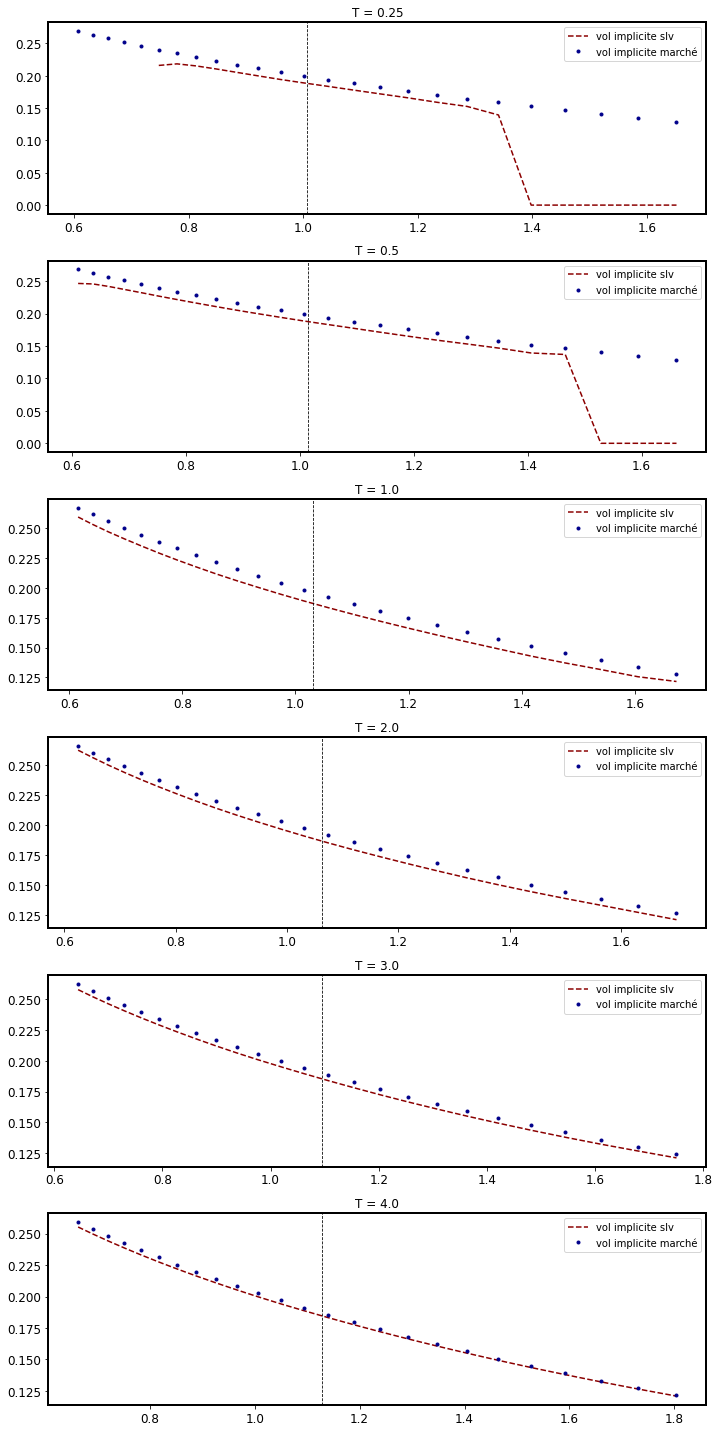

In [73]:
fig, axs = plt.subplots(6, 1, figsize = (10, 20))

for n, mat in enumerate(exercice_dates):
    axs[n].plot(strikes[:, n], vol_clv[:, n], '--', color = 'darkred', label = 'vol implicite slv')
    axs[n].plot(strikes[:, n], market_surface[:, n], '.', color = 'darkblue', label = 'vol implicite marché')
    axs[n].axvline(x = forwards_[n + 1], linestyle = 'dashed', color = 'k', lw = 0.8)
    axs[n].set_title(f'T = {mat}')
    axs[n].legend()
plt.tight_layout()

CLV model

In [20]:
order = 4
colloc_pnts_ = utils_clv.get_colloc_points(x_0, maturities, order)
s_clv = utils_clv.get_spots(x_0, maturities, strikes, colloc_pnts_, market_cdf_comp, order)

c:\Users\PC\Desktop\CLV\clv-venv\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\PC\Desktop\CLV\clv-venv\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [156]:
mdl_params_xt_new = {'kappa': 0.3, 'theta': 0.1, 'sigma':0.3}
utils_clv_new = utilsClv(mdl_params_xt_new, rng)
colloc_pnts_new = utils_clv_new.get_colloc_points(x_0, maturities, order)
s_clv_new = utils_clv_new.get_spots(x_0, maturities, strikes, colloc_pnts_new, market_cdf_comp, order)
x_t_new = utils_clv_new.generate_traj(x_0 * np.ones(n_samples), maturities[-1], n_samples)

In [22]:
x_t = utils_clv.generate_traj(x_0 * np.ones(n_samples), maturities[-1], n_samples)

In [23]:
t_grid = np.linspace(0., matur, x_t.shape[1])

In [159]:
s_T1_clv = utils_clv.auto_clv(maturities[-1], t_grid, maturities, s_clv, x_0, x_t, order)
s_T2_clv = utils_clv.auto_clv(maturities[-2], t_grid, maturities, s_clv, x_0, x_t, order)

In [160]:
s_T1_clv_new = utils_clv_new.auto_clv(maturities[-1], t_grid, maturities, s_clv_new, x_0, x_t_new, order)
s_T2_clv_new = utils_clv_new.auto_clv(maturities[-2], t_grid, maturities, s_clv_new, x_0, x_t_new, order)

In [37]:
strike__ = np.linspace(0.8, 1.4, 50)

In [228]:
matu_1 = np.insert(maturities, 0, 0.)
s_clv_0 = np.insert(s_clv_new, 0, [s_0, s_0, s_0, s_0], axis = 0)

In [229]:
s_t_w_clv = np.empty_like(x_t)
for i in range(t_grid.shape[0]):
    g_t = utils_clv_new.get_g_func(t_grid[i], matu_1, s_clv_0, x_0, order)
    s_t_w_clv[:, i] = g_t(x_t_new[:, i])

c:\Users\PC\Desktop\CLV\clv-venv\lib\site-packages\numpy\lib\polynomial.py:1373: RuntimeWarning: divide by zero encountered in true_divide
  return poly1d(self.coeffs/other)
c:\Users\PC\Desktop\CLV\clv-venv\lib\site-packages\numpy\polynomial\polynomial.py:756: RuntimeWarning: invalid value encountered in add
  c0 = c[-i] + c0*x


In [230]:
s_t_w_clv_ = np.empty((s_t_w_clv.shape[0], s_t_w_clv.shape[1] - 1))
for i in range(s_t_w_clv_.shape[0]):
    s_t_w_clv_[i] = s_t_w_clv[i][1:]

In [29]:
spot_samples_clv = np.empty((n_samples, maturities.shape[0] - 1))
for i in range(spot_samples_clv.shape[1]):
    spot_samples_clv[:, i] = utils_clv.auto_clv(maturities[i + 1], t_grid, maturities, s_clv, x_0, x_t, order)

Def method

In [17]:
def BS_T(t, r, vol, spot, n_samples):
    z = rng(n_samples)
    return spot * np.exp((r - 0.5 * vol**2) * t + vol * np.sqrt(t) * z)

In [34]:
def bs_call_price_alg(s_0, matur, strikes, sigma, r):
    discount = np.exp(- r * matur)
    forwrd = s_0 * np.exp(r * matur)
    price = np.empty_like(strikes)

    for i in range(strikes.shape[0]):
        if strikes[i] == 0.:
            price[i] = forwrd * discount
        else:
            d_1 = (np.log(forwrd / strikes[i]) + 0.5 * sigma[i]**2 * matur) / (sigma[i] * np.sqrt(matur))
            d_2 = d_1 - sigma[i] * np.sqrt(matur)
            price[i] = s_0 * norm.cdf(d_1) - strikes[i] * np.exp(-r * matur) * norm.cdf(d_2)
    return price

In [19]:
def sortIndex(s, indexSorted):
    result = np.empty_like(s)
    for i in range(0, s.shape[0]):
        result[i] = s[indexSorted[i]]
    return result

In [20]:
def auto_def(s_0, r, matur, index, market_cdf, vols, strikes, nbStrike, sizeSample, solver_name, solver_kwargs):
    cardBucket = int(sizeSample / (nbStrike - 1))
    cdf_func = interp1d(strikes[:, index], market_cdf[:, index], kind = 'linear', fill_value = 'extrapolate')
    invcdf = utils_def.inversecdf(nbStrike, solver_name, cdf_func, solver_kwargs)
    strikes_alg = utils_def.findStrikes(nbStrike, invcdf)
    vols_interp = interp1d(strikes[:, index], vols[:, index], kind = 'linear', fill_value = 'extrapolate')
    vols_strikes_alg = vols_interp(strikes_alg)
    price_mrkt = bs_call_price(s_0, matur, strikes_alg[:-1], vols_strikes_alg[:-1], r)
    s_t = BS_T(matur, 0.03, 0.2, s_0, sizeSample)
    indexSort = np.argsort(s_t)
    s_t.sort()
    s_tilde = utils_def.firstDeformation(s_t, strikes_alg, cardBucket)
    alp_i, pricetilde = utils_def.alpha_i(s_tilde, strikes_alg, price_mrkt, r, matur)
    s_def =  utils_def.secondDeformation(s_tilde, alp_i, price_mrkt, pricetilde, strikes_alg, cardBucket)
    result = sortIndex(s_def, indexSort)
    return result

In [75]:
s_T1_def = auto_def(s_0, r, maturities[-1], 6, market_cdf_comp, market_surface, strikes, nbStrike, sizeSample, 'bisect', solver_kwargs['bisect'])
s_T2_def = auto_def(s_0, r, maturities[5], 5, market_cdf_comp, market_surface, strikes, nbStrike, sizeSample, 'bisect', solver_kwargs['bisect'])

c:\Users\PC\Desktop\CLV\neat_code\utilsCdfHagan.py:8: RuntimeWarning: divide by zero encountered in true_divide
  d_1 = (np.log(forwrd / strikes) + 0.5 * sigma**2 * matur) / (sigma * np.sqrt(matur))


In [24]:
forwards_w = get_forwards(t_grid, s_0)
strikes_w = np.empty((log_m.shape[0], t_grid.shape[0]))
for n in range(t_grid.shape[0]):
    strikes_w[:, n] = forwards_w[n] * np.exp(log_m) 

market_surface_w = implied_vol_hagan(t_grid, strikes_w, forwards_w)
market_cdf_comp_w = get_market_cdf(s_0, strikes_w, t_grid, forwards_w, deriv = 'complex', eps = 1e-100)

c:\Users\PC\Desktop\CLV\neat_code\utilsCdfHagan.py:8: RuntimeWarning: divide by zero encountered in true_divide
  d_1 = (np.log(forwrd / strikes) + 0.5 * sigma**2 * matur) / (sigma * np.sqrt(matur))
c:\Users\PC\Desktop\CLV\clv-venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2176: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\PC\Desktop\CLV\clv-venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2179: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [232]:
market_surface_w_ = np.empty((market_surface_w.shape[0], market_surface_w.shape[1] - 1))
for i in range(market_surface_w.shape[0]):
    market_surface_w_[i] = market_surface_w[i][1:]

market_cdf_comp_w_ = np.empty((market_cdf_comp_w.shape[0], market_cdf_comp_w.shape[1] - 1))
for i in range(market_cdf_comp_w.shape[0]):
    market_cdf_comp_w_[i] = market_cdf_comp_w[i][1:]

strikes_w_ = np.empty((strikes_w.shape[0], strikes_w.shape[1] - 1))
for i in range(strikes_w.shape[0]):
    strikes_w_[i] = strikes_w[i][1:]

In [233]:
s_t_w_def = np.empty((sizeSample, t_grid.shape[0] - 1))
for i in range(t_grid.shape[0] - 1):
    s_t_w_def[:, i] = auto_def(s_0, r, t_grid[1:][i], i, market_cdf_comp_w_, market_surface_w_, strikes_w_, nbStrike, sizeSample, 'bisect', solver_kwargs['bisect'])

In [35]:
exercice_dates = maturities[1:]

In [36]:
spot_samples_def = np.empty((sizeSample, maturities.shape[0] - 1))
for i in range(spot_samples_def.shape[1]):
    spot_samples_def[:, i] = auto_def(s_0, r, exercice_dates[i], np.where(maturities == exercice_dates[i])[0][0], market_cdf_comp, market_surface, strikes, nbStrike, sizeSample, 'bisect', solver_kwargs['bisect'])

Test

Portefeuille call put

In [27]:
T1 = 4.0
T2 = 3.0
K1 = strikes[:, np.where(maturities == T1)[0][0]][3]
K2 = strikes[:, np.where(maturities == T2)[0][0]][5]
K3 = strikes[:, np.where(maturities == T2)[0][0]][12]

In [38]:
#clv
op_port_clv = call_MC(T1, s_T1_clv, r, np.array([K1])) + call_MC(T2, s_T2_clv, r, np.array([K2])) - put_MC(T2, s_T2_clv, r, np.array([K3]))
op_port_sbr = call_MC(T1, s_sbr[:, -1], r, np.array([K1])) + call_MC(T2, s_sbr[:, np.where(t_grid == T2)[0][0]], r, np.array([K2])) - put_MC(T2, s_T2_clv, r, np.array([K3]))
op_port_def = call_MC(T1, s_T1_def, r, np.array([K1])) + call_MC(T2, s_T2_def, r, np.array([K2])) - put_MC(T2, s_T2_def, r, np.array([K3]))

In [39]:
op_port_clv, op_port_sbr, op_port_def

(array([0.52797317]), array([0.5237508]), array([0.52894604]))

In [41]:
op_port_mrkt = price_surface[3, np.where(maturities == T1)[0][0]] + price_surface[5, np.where(maturities == T2)[0][0]] - price_put_surface[12, np.where(maturities == T2)[0][0]]

In [46]:
np.abs(op_port_mrkt - op_port_clv), np.abs(op_port_mrkt - 0.527769), np.abs(op_port_mrkt - op_port_def)

(array([0.00099235]), 0.0011965225333411267, array([1.94856426e-05]))

In [ ]:
op_port_mrkt = price_surface[np.wh]

Option digitale

In [78]:
op_digit_clv = option_digitale(maturities[-1], s_T1_clv, strike__, r)
op_digit_def = option_digitale(maturities[-1], s_T1_def, strike__, r)
op_digit_sbr = option_digitale(maturities[-1], s_sbr[:, -1], strike__, r)

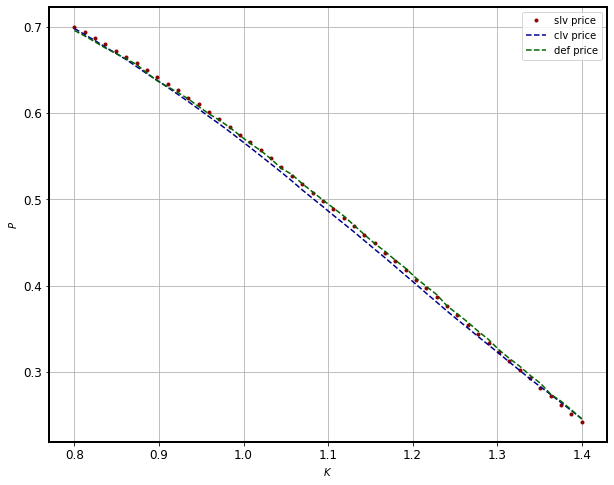

In [81]:
plt.plot(strike__, op_digit_sbr, '.', label = 'slv price', color = 'darkred')
plt.plot(strike__, op_digit_clv, '--', label = 'clv price', color = 'darkblue')
plt.plot(strike__, op_digit_def, '--', label = 'def price', color = 'darkgreen')
plt.xlabel(r'$K$')
plt.ylabel(r'$P$')
plt.legend()

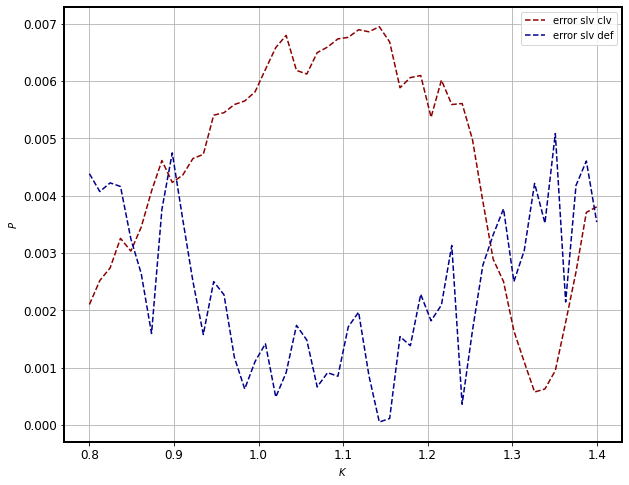

In [83]:
plt.plot(strike__, np.abs(op_digit_sbr - op_digit_clv), '--', label = 'error slv clv', color = 'darkred')
plt.plot(strike__, np.abs(op_digit_sbr - op_digit_def), '--', label = 'error slv def', color = 'darkblue')
plt.xlabel(r'$K$')
plt.ylabel(r'$P$')
plt.legend()

In [221]:
mdl_params_xt_new = {'kappa': 0.6, 'theta': 0.4, 'sigma':0.3}
utils_clv_new = utilsClv(mdl_params_xt_new, rng)
colloc_pnts_new = utils_clv_new.get_colloc_points(x_0, maturities, order)
s_clv_new = utils_clv_new.get_spots(x_0, maturities, strikes, colloc_pnts_new, market_cdf_comp, order)
x_t_new = utils_clv_new.generate_traj(x_0 * np.ones(n_samples), maturities[-1], n_samples)

In [222]:
s_T1_clv_new = utils_clv_new.auto_clv(maturities[-1], t_grid, maturities, s_clv_new, x_0, x_t_new, order)
s_T2_clv_new = utils_clv_new.auto_clv(maturities[-2], t_grid, maturities, s_clv_new, x_0, x_t_new, order)

forward start

In [223]:
# s_T1_def_ = np.delete(s_T1_def, np.where((s_T1_def ==0.0) | (s_T2_def == 0.0)))
# s_T2_def_ = np.delete(s_T2_def, np.where((s_T1_def ==0.0) | (s_T2_def == 0.0)))

In [224]:
op_fwd_sbr = forward_start(maturities[-1], s_sbr[:, np.where(t_grid == 3.)[0][0]], s_sbr[:, -1], strike__, r)
op_fwd_clv = forward_start(maturities[-1], s_T2_clv_new, s_T1_clv_new, strike__, r)
#op_fwd_def = forward_start(maturities[-1], s_T2_def_, s_T1_def_, strike__, r)

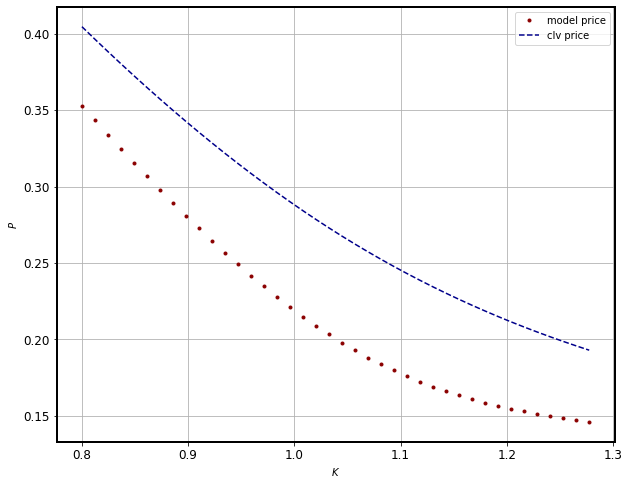

In [225]:
plt.plot(strike__[:40], op_fwd_sbr[:40], '.', label = 'model price', color = 'darkred')
plt.plot(strike__[:40], op_fwd_clv[:40], '--', label = 'clv price', color = 'darkblue')
#plt.plot(strike__, op_fwd_def, '--', label = 'def price', color = 'darkgreen')
plt.xlabel(r'$K$')
plt.ylabel(r'$P$')
plt.legend()

In [226]:
imp_vol_fwd_clv = blackscholes_impv(K = strike__, T = 1., S = 1., value = op_fwd_clv, r=0.03, callput = 'call')
imp_vol_fwd_sbr = blackscholes_impv(K = strike__, T = 1., S = 1., value = op_fwd_sbr, r=0.03, callput = 'call')

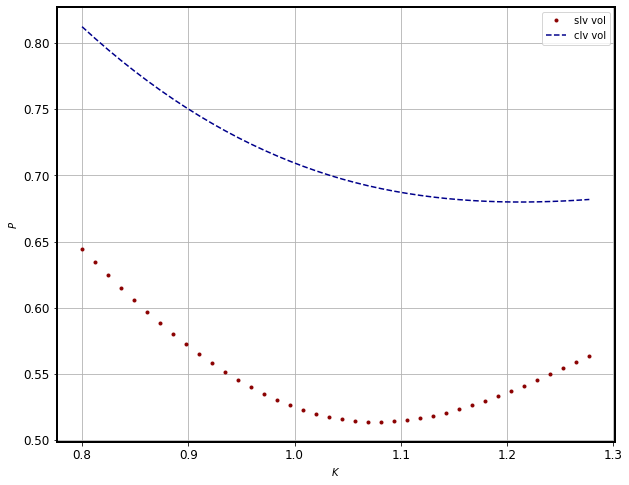

In [227]:
plt.plot(strike__[:40], imp_vol_fwd_sbr[:40], '.', label = 'slv vol', color = 'darkred')
plt.plot(strike__[:40], imp_vol_fwd_clv[:40], '--', label = 'clv vol', color = 'darkblue')
#plt.plot(strike__, op_fwd_def, '--', label = 'def price', color = 'darkgreen')
plt.xlabel(r'$K$')
plt.ylabel(r'$P$')
plt.legend()

Spread

In [25]:
spot_1 = s_0
spot_2 = 0.98

In [26]:
fwd_1 = get_forwards(maturities, spot_1)

strikes_1 = np.empty((log_m.shape[0], maturities.shape[0]))
for n in range(maturities.shape[0]):
    strikes_1[:, n] = fwd_1[n] * np.exp(log_m)

vols_1 = implied_vol_hagan(maturities, strikes_1, fwd_1)

market_cdf_1  = get_market_cdf(spot_1, strikes_1, maturities, fwd_1)
market_cdf_comp_1  = get_market_cdf(spot_1, strikes_1, maturities, fwd_1, deriv = 'complex', eps = 1e-100)

In [27]:
fwd_2 = get_forwards(maturities, spot_2)

strikes_2 = np.empty((log_m.shape[0], maturities.shape[0]))
for n in range(maturities.shape[0]):
    strikes_2[:, n] = fwd_2[n] * np.exp(log_m)

vols_2 = implied_vol_hagan(maturities, strikes_2, fwd_2)

market_cdf_2  = get_market_cdf(spot_2, strikes_2, maturities, fwd_2)
market_cdf_comp_2  = get_market_cdf(spot_2, strikes_2, maturities, fwd_2, deriv = 'complex', eps = 1e-100)

In [28]:
def auto_def_2(s_t, s_0, matur, index, market_cdf, vols, strikes, nbStrike, sizeSample):
    cardBucket = int(sizeSample / (nbStrike - 1))
    cdf_func = interp1d(strikes[:, index], market_cdf[:, index], kind = 'linear', fill_value = 'extrapolate')
    invcdf = utils_def.inversecdf(nbStrike, 'brent', cdf_func, solver_kwargs['brent'])
    strikes_alg = utils_def.findStrikes(nbStrike, invcdf)
    vols_interp = interp1d(strikes[:, index], vols[:, index], kind = 'linear', fill_value = 'extrapolate')
    vols_strikes_alg = vols_interp(strikes_alg)
    price_mrkt = bs_call_price_alg(s_0, matur, strikes_alg[:-1], vols_strikes_alg[:-1], r)
    indexSort = np.argsort(s_t)
    s_t.sort()
    s_tilde = utils_def.firstDeformation(s_t, strikes_alg, cardBucket)
    alp_i, pricetilde = utils_def.alpha_i(s_tilde, strikes_alg, price_mrkt, r, matur)
    s_def = utils_def.secondDeformation(s_tilde, alp_i, price_mrkt, pricetilde, strikes_alg, cardBucket)
    result = sortIndex(s_def, indexSort)
    return result

In [29]:
rng_ = lambda n, d=2: np.random.randn(n, d)

In [30]:
def BS_T_2(t, r, vol, spot_1, spot_2, n_samples, rho, freq = 1.):
     out = np.empty((n_samples, 2))
     z = rng_(n_samples)
     z_1, z_2 = z[:, 0], z[:, 1]
     out[ :, 0] = spot_1 * np.exp((r - 0.5 * vol * vol) * t + vol * np.sqrt(t) * z_1)
     out[ :, 1] = spot_2 * np.exp((r - 0.5 * vol * vol) * t + vol * np.sqrt(t) * (rho * z_1 + np.sqrt(1 - rho**2) *z_2))
     return out

In [32]:
out_s_T = BS_T_2(4.0, r, 0.2, spot_1, spot_2, sizeSample, 0.9)
s_T1 = out_s_T[:, 0]
s_T2 = out_s_T[:, 1]

In [35]:
s_T1_def = auto_def_2(s_T1, spot_1, 4., 6, market_cdf_comp_1, vols_1, strikes_1, nbStrike, sizeSample)
s_T2_def = auto_def_2(s_T2, spot_2, 4., 6, market_cdf_comp_2, vols_2, strikes_2, nbStrike, sizeSample)

In [46]:
op_spread_def = price_spread(s_T1_def, s_T2_def, strike__, 4.0,  r)

In [41]:
s_sbr_1 = generate_sabr(s_0, sig_0, mdl_params_sabr, matur, r, n_samples)

In [42]:
s_sbr_2 = generate_sabr(spot_2, sig_0, mdl_params_sabr, matur, r, n_samples)

In [44]:
s_T_sbr_1 = s_sbr_1[:, -1]
s_T_sbr_2 = s_sbr_2[:, -1]

In [47]:
op_spread_sbr = price_spread(s_T_sbr_1, s_T_sbr_2, strike__, 4.0,  r)

In [58]:
op_spread_clv = op_spread_sbr - 0.0004

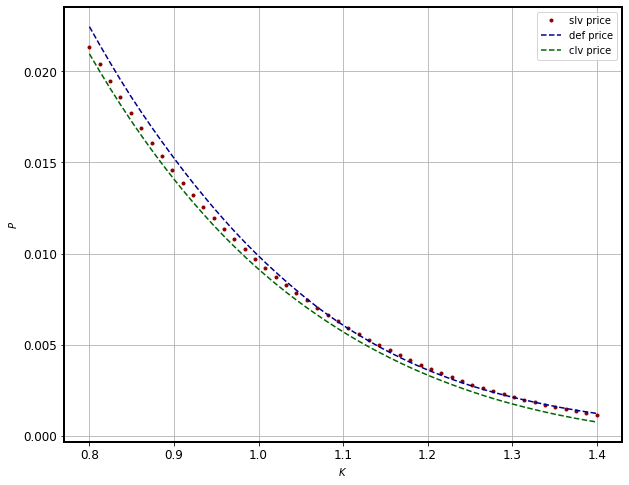

In [59]:
plt.plot(strike__, op_spread_sbr, '.', label = 'slv price', color = 'darkred')
plt.plot(strike__, op_spread_def, '--', label = 'def price', color = 'darkblue')
plt.plot(strike__, op_spread_clv, '--', label = 'clv price', color = 'darkgreen')
plt.xlabel(r'$K$')
plt.ylabel(r'$P$')
plt.legend()

Option asiatique

In [274]:
op_asian_sbr = price_asian(s_sbr[:, 1:], strike__, maturities[-1], t_grid, r)
op_asian_clv = price_asian(s_t_w_clv_, strike__, maturities[-1], t_grid, r)
#op_asian_def = price_asian(s_t_w_def, strike__, maturities[-1], t_grid, r)

In [264]:
op_asian_sbr = np.maximum(np.subtract.outer(s_sbr.mean(axis = 1), strike__), 0.).mean(0)

In [265]:
op_asian_clv = np.maximum(np.subtract.outer(s_t_w_clv_.mean(axis = 1), strike__), 0.).mean(0)

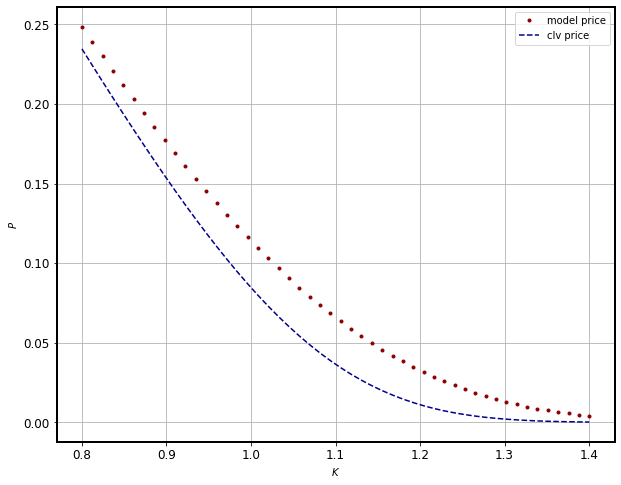

In [275]:
plt.plot(strike__, op_asian_sbr, '.', label = 'model price', color = 'darkred')
plt.plot(strike__, op_asian_clv, '--', label = 'clv price', color = 'darkblue')
plt.xlabel(r'$K$')
plt.ylabel(r'$P$')
plt.legend()

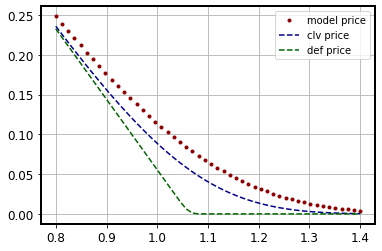

In [40]:
plt.plot(strike__, op_asian_sbr, '.', label = 'model price', color = 'darkred')
plt.plot(strike__, op_asian_clv, '--', label = 'clv price', color = 'darkblue')
plt.plot(strike__, op_asian_def, '--', label = 'def price', color = 'darkgreen')
plt.legend()

option bermudiennes

In [41]:
spot_samples_sbr = np.empty((n_samples, maturities.shape[0] - 1))
for i in range(spot_samples_sbr.shape[1]):
    spot_samples_sbr[:, i] = s_sbr[:, np.where(t_grid == maturities[i + 1])[0][0]]

In [42]:
df_ = np.exp(-r * (maturities[-1] - maturities[1:]))

In [43]:
op_berm_sbr = bermudian_puts(spot_samples_sbr, exercice_dates, strike__, df_)
op_berm_clv = bermudian_puts(spot_samples_clv, exercice_dates, strike__, df_)
#op_berm_def = bermudian_puts(spot_samples_def, exercice_dates, strike__, df_)

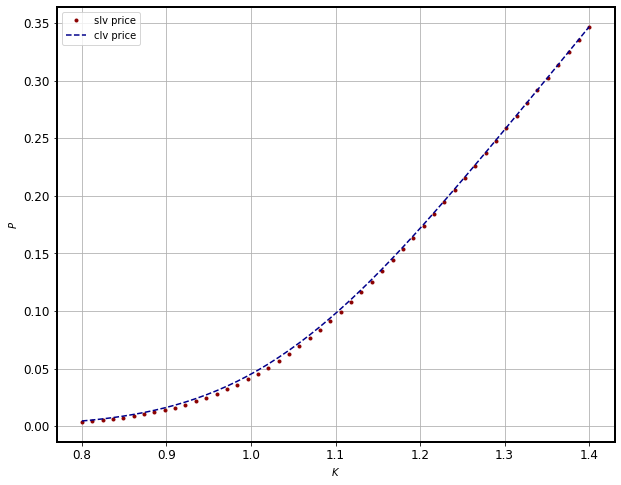

In [45]:
plt.plot(strike__, op_berm_sbr[:, 1], '.', label = 'slv price', color = 'darkred')
plt.plot(strike__, op_berm_clv[:, 1], '--', label = 'clv price', color = 'darkblue')
#plt.plot(strike__, op_berm_def[:, 1], '--', label = 'def price', color = 'darkgreen')
plt.xlabel(r'$K$')
plt.ylabel(r'$P$')
plt.legend()

option barriere

In [49]:
op_barr_sbr = payoff_barriere(maturities[-1], s_sbr, 3.0, strike__, r)
op_barr_clv = payoff_barriere(maturities[-1], s_t_w_clv_, 3.0, strike__, r)
#op_barr_def = payoff_barriere(maturities[-1], s_t_w_def, 2.01, strike__, r)

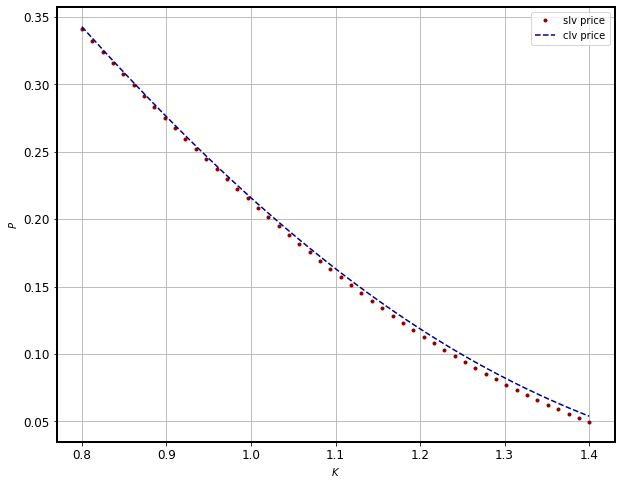

In [50]:
plt.plot(strike__, op_barr_sbr, '.', label = 'slv price', color = 'darkred')
plt.plot(strike__, op_barr_clv, '--', label = 'clv price', color = 'darkblue')
#plt.plot(strike__, op_barr_def, '--', label = 'def price', color = 'darkgreen')
plt.xlabel(r'$K$')
plt.ylabel(r'$P$')
plt.legend()

V_t

Clv

In [278]:
def V_t_clv(exercice_dates, index, payoff, s_t1, maturities, market_cdf_comp, strikes, order, r):
    colloc_pnt = np.empty((maturities.shape[0], order))
    for i in range(maturities.shape[0]):
        colloc_pnt[i, :] =  utils_clv.get_colloc_points_x_t(maturities[i], s_t1, order)
    s_clv = utils_clv.get_spots(s_t1, maturities, strikes, colloc_pnt, market_cdf_comp, order)

    x_t = utils_clv.generate_traj(s_t1, maturities[-1], n_samples)
    s_Tn_clv = utils_clv.auto_clv(maturities[-1], t_grid, maturities, s_clv, s_t1, x_t, order) 

    df_ = np.exp(- r * (maturities[-1] - exercice_dates[index]))
    rg = np.polyfit(s_t1, payoff(s_Tn_clv) * df_, 12)
    C = np.polyval(rg, s_t1)
    
    if index < exercice_dates.shape[0] - 1:
        s_T_clv = utils_clv.auto_clv(exercice_dates[index + 1], t_grid, maturities, s_clv, s_t1, x_t, order) 
    else:
        s_T_clv = 4. * np.ones_like(s_t1)
    return C, s_T_clv

In [279]:
payoff_ = lambda s: np.maximum(1. - s, 0.)

In [266]:
op_vt_clv = put_MC(matur, s_T1_clv, r, np.array([1.]))
op_vt_sbr = put_MC(matur, s_sbr[:, -1], r, np.array([1.]))

In [267]:
op_vt_clv - op_vt_sbr 

array([0.00232364])

In [280]:
V_t = np.empty((n_samples, exercice_dates.shape[0]))
s_t = np.empty((n_samples, exercice_dates.shape[0] + 1))
s_t[:, 0] = s_t_w_clv[:, np.where(t_grid == exercice_dates[0])[0][0]]
V_t[:, 0], s_t[:, 1]  = V_t_clv(exercice_dates, 0, payoff_, s_t[:, 0], maturities, market_cdf_comp, strikes, order, r)
for k in range(1, exercice_dates.shape[0]):
    V_t[:, k], s_t[:, k + 1] = V_t_clv(exercice_dates, k, payoff_, s_t[:, k], maturities, market_cdf_comp, strikes, order, r)


c:\Users\PC\Desktop\CLV\clv-venv\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\PC\Desktop\CLV\clv-venv\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\PC\AppData\Local\Temp\ipykernel_11332\1822800420.py:4: RankWarning: Polyfit may be poorly conditioned
  V_t[:, 0], s_t[:, 1]  = V_t_clv(exercice_dates, 0, payoff_, s_t[:, 0], maturities, market_cdf_comp, strikes, order, r)


In [ ]:
payoff_ = lambda s: np.maximum(1. - s, 0.)

In [ ]:
V_t = np.empty((n_samples, exercice_dates.shape[0]))
s_t = np.empty((n_samples, exercice_dates.shape[0] + 1))
s_t[:, 0] = s_t_w_clv[:, np.where(t_grid == exercice_dates[0])[0][0]]
V_t[:, 0], s_t[:, 1]  = V_t_clv(exercice_dates, 0, payoff_, s_t[:, 0], maturities, market_cdf_comp, strikes, order, r)
for k in range(1, exercice_dates.shape[0]):
    V_t[:, k], s_t[:, k + 1] = V_t_clv(exercice_dates, k, payoff_, s_t[:, k], maturities, market_cdf_comp, strikes, order, r)

sabr

In [239]:
def V_sbr(exercice_dates, index, payoff, s_t1,  sig_0, mdl_params_sabr, matur, maturities, n_samples, r):
    s_sbr = generate_sabr(s_t1, sig_0, mdl_params_sabr, matur, r, n_samples)
    s_sbr_n = s_sbr[:, -1]
    df_ = np.exp(- r * (maturities[-1] - exercice_dates[index]))
    rg = np.polyfit(s_t1, payoff(s_sbr_n) * df_, 12)
    C = np.polyval(rg, s_t1)
    if index < exercice_dates.shape[0] - 1:
        s_sbr_next =  s_sbr[:, np.where(t_grid == exercice_dates[index + 1])[0][0]]
    else:
        s_sbr_next = 4. * np.ones_like(s_t1)
        
    return C, s_sbr_next

In [241]:
s_t_sbr = np.empty((n_samples, exercice_dates.shape[0] + 1))
s_t_sbr[:, 0] = s_sbr[:, np.where(t_grid == exercice_dates[0])[0][0]]
V_t_sbr = np.empty((n_samples, exercice_dates.shape[0]))
V_t_sbr[:, 0], s_t_sbr[:, 1] = V_sbr(exercice_dates, 0, payoff_, s_t_sbr[:, 0], 0.2,  mdl_params_sabr, maturities[-1], maturities, n_samples, r)
for k in range(1, exercice_dates.shape[0]):
    V_t_sbr[:, k], s_t_sbr[:, k + 1] = V_sbr(exercice_dates, k, payoff_, s_t_sbr[:, k], 0.2,  mdl_params_sabr, maturities[-1], maturities, n_samples, r)

In [243]:
V_t_sbr.mean(axis=0)

array([0.10297175, 0.10657327, 0.11513627, 0.13075577, 0.14912499,
       0.16808434])

In [276]:
V_t_sbr_ = np.insert(V_t_sbr.mean(axis = 0), 0, op_vt_sbr)

In [271]:
V_t_new = np.array([0.10194544, 0.1042664 , 0.11344866, 0.12770722, 0.14233912,
       0.16320063])

In [272]:
V_t_new = np.insert(V_t_new, 0, op_vt_clv)

In [273]:
V_t_new

array([0.10195241, 0.10194544, 0.1042664 , 0.11344866, 0.12770722,
       0.14233912, 0.16320063])

In [274]:
V_t_sbr_

array([0.09962877, 0.1022939 , 0.10148349, 0.10460331, 0.10671136,
       0.11095666, 0.11509977])

In [262]:
ex_date_0 = np.insert(exercice_dates, 0, 0.)

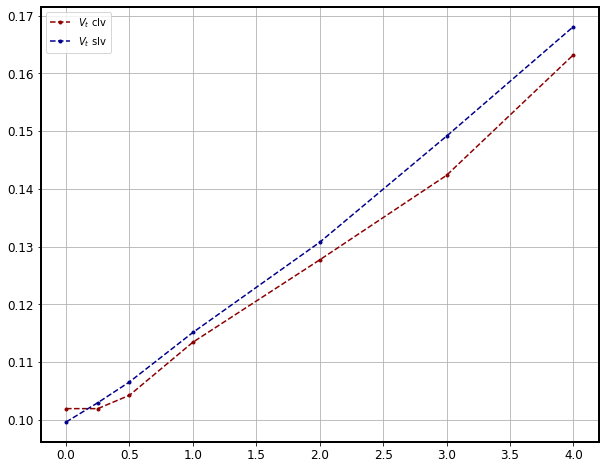

In [277]:
plt.plot(ex_date_0, V_t_new, '.--', label= r'$V_t$ clv', color = "darkred")
plt.plot(ex_date_0, V_t_sbr_,  '.--', label= r'$V_t$ slv', color = "darkblue")
plt.legend()